# Sensitivity Analysis on the beam model through creation of a metamodel

In [1]:
# from here on, all our modules and helper functions are imported
from _base_algorithms import * 


Bad key savefig.frameon in file /home/kramer84/anaconda3/envs/ot_traits_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/kramer84/anaconda3/envs/ot_traits_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/kramer84/anaconda3/envs/ot_traits_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log fi

len vertices is: 101


In [2]:
# Definition of the model parameters 
dim          = 1
n_elements   = 99
min_vertices = 0    #mm
max_vertices = 1000 #mm

coef_var = .05
mean_young,  mean_diam  = 210000, 10  #MPa, mm
scale_young, scale_diam = 300,    250 #mm, mm
nu_young,    nu_diam    = 5,      5   #scalar

mean_pos_force,  mean_norm_force   = 500, 100 #N, mm
sigma_pos_force, sigma_norm_force  = 25,  5   #N, mm

fem_vertices = get_fem_vertices(min_vertices, max_vertices, n_elements)

# Karhunen-Loeve decomposition of two stochastic processes: Young's Modulus and Diameter 
# amplitude = [mean*coef_var]*dim,scale = [scale]*dim 
 
kl_results_E = get_process_kl_decomposition(mean = mean_young, coef_var = coef_var, scale = scale_young, 
                    nu = nu_young, mesh = fem_vertices, dimension = dim, name = 'E_', threshold= 1e-3)

kl_results_D = get_process_kl_decomposition(mean = mean_diam, coef_var = coef_var, scale = scale_diam, 
                    nu = nu_diam, mesh = fem_vertices, dimension = dim, name = 'D_', threshold= 1e-3)

# The two scalar random variables : 
pos_force = ot.Normal(mean_pos_force, sigma_pos_force)
pos_force.setName('F_Pos_')

norm_force  = ot.Normal(mean_norm_force, sigma_norm_force)
norm_force.setName('F_Norm_')

In [3]:
kl_results_list = [kl_results_E, kl_results_D, pos_force, norm_force]
AggregatedKLRes = klfs.AggregatedKarhunenLoeveResults(kl_results_list)
AggregatedKLRes.setMean(0, mean_young) # At other indices the means are initialized from the distributions
AggregatedKLRes.setMean(1, mean_diam) 
AggregatedKLRes.setLiftWithMean(True)
RandomNormalVector = getRandomNormalVector(AggregatedKLRes)

The mean value of distribution "F_Pos_" at index 2 of type Normal is not 0.
Distribution recentered and mean added to list of means
Set the "liftWithMean" flag to true if you want to include the mean.
The mean value of distribution "F_Norm_" at index 3 of type Normal is not 0.
Distribution recentered and mean added to list of means
Set the "liftWithMean" flag to true if you want to include the mean.


In [4]:
# definition of the model :
_MODEL = MODEL.PureBeam()
# initialization of the function wrapper : 
FUNC = klfs.KarhunenLoeveGeneralizedFunctionWrapper(
            AggregatedKarhunenLoeveResults = AggregatedKLRes,
            func        = None, 
            func_sample = _MODEL.batchEval,
            n_outputs   = 2)
FUNC_wSave = function_with_save_wrapper(FUNC)

In [5]:
doe_kriging_LHS25  = optimizedLHS(RandomNormalVector, 25, 125936931580)      #SEED: 125936931580
doe_kriging_LHS50  = optimizedLHS(RandomNormalVector, 50, 14305853687720)    #SEED: 14305853687720
doe_kriging_LHS150 = optimizedLHS(RandomNormalVector, 150, 758295729577843)  #SEED: 758295729577843
doe_kriging_LHS300 = optimizedLHS(RandomNormalVector, 300, 643292187861)     #SEED: 643292187861

doe_kriging_validation = optimizedLHS(RandomNormalVector, 1000, 315681856881426) #SEED: 315681856881426

doe_sobol_experiment_N1000, experiment_N1000 = getSobolExperiment(AggregatedKLRes, 1000, 104850184570776510) #SEED:104850184570776510

Elapsed time: 0.0677 seconds
Elapsed time: 0.2413 seconds
Elapsed time: 1.9484 seconds
Elapsed time: 7.7860 seconds
Elapsed time: 88.2998 seconds
Samples A and B of size 1000 and dimension 15
Experiment of size 6000 and dimension 15
Elapsed time: 0.0162 seconds


In [6]:
#Evaluation of the function on our design of experiments
#For the Kriging:
_, doe_kriging_LHS25_VM, doe_kriging_LHS25_MD = FUNC_wSave(doe_kriging_LHS25, 'doe_kriging_LHS25')
_, doe_kriging_LHS50_VM, doe_kriging_LHS50_MD = FUNC_wSave(doe_kriging_LHS50, 'doe_kriging_LHS50')
_, doe_kriging_LHS150_VM, doe_kriging_LHS150_MD = FUNC_wSave(doe_kriging_LHS150, 'doe_kriging_LHS150')
_, doe_kriging_LHS300_VM, doe_kriging_LHS300_MD = FUNC_wSave(doe_kriging_LHS300, 'doe_kriging_LHS300')
#For the Sobol Indices
_, doe_sobol_experiment_N1000_VM, doe_sobol_experiment_N1000_MD = FUNC_wSave(doe_sobol_experiment_N1000, 'doe_sobol_experiment_N1000')

_, doe_kriging_validation_VM, doe_kriging_validation_MD = FUNC_wSave(doe_kriging_validation, 'doe_kriging_validation')

Lifting as process sample
field E shape (25, 100)
var_Fnor shape (25,)
field_E 209540.9065176858 field_D 10.005532874507608 var_Fpos 500.03397600813713 var_Fnor 100.0421740520542


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.1s finished
/home/kramer84/anaconda3/envs/ot_traits_env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


shape deflection:  (25, 101)  should be [N,10X] something
deflection std deviation  4.222328411606992
Using the batch evaluation function. Assumes that the outputs are in the
same order than for the single evaluation function. This one should only
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (25, 100) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (1, 25) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns process samples of dimension 1
Lifting as process sample
field E shape (50, 100)
var_Fnor shape (50,)
field_E 210098.1864444275 field_D 9.996006883813106 var_Fpos 499.8719040555004 var_Fnor 99.99058223098719


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.9s finished
/home/kramer84/anaconda3/envs/ot_traits_env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (50, 101)  should be [N,10X] something
deflection std deviation  4.074776384015145
Using the batch evaluation function. Assumes that the outputs are in the
same order than for the single evaluation function. This one should only
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (50, 100) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (1, 50) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns process samples of dimension 1
Lifting as process sample
field E shape (150, 100)
var_Fnor shape (150,)
field_E 209995.64209072068 field_D 9.998742900677582 var_Fpos 500.10189778823485 var_Fnor 100.00728769954287


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (150, 101)  should be [N,10X] something
deflection std deviation  3.8327580969108643
Using the batch evaluation function. Assumes that the outputs are in the
same order than for the single evaluation function. This one should only
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (150, 100) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (1, 150) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns process samples of dimension 1
Lifting as process sample
field E shape (300, 100)
var_Fnor shape (300,)
field_E 209970.16814134887 field_D 9.999920870044713 var_Fpos 500.0354462052584 var_Fnor 99.99873413105156


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.2s finished


shape deflection:  (300, 101)  should be [N,10X] something
deflection std deviation  3.727602169119225
Using the batch evaluation function. Assumes that the outputs are in the
same order than for the single evaluation function. This one should only
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (300, 100) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (1, 300) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns process samples of dimension 1
Lifting as process sample
field E shape (6000, 100)
var_Fnor shape (6000,)
field_E 209930.08536417544 field_D 9.990053427081232 var_Fpos 499.7213301534985 var_Fnor 99.94693124656756


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min


did not manage to evaluate batch function


TypeError: batchEval() takes 2 positional arguments but 5 were given

In [11]:
# Creation of a metamodel through kriging
kriging_doe_LHS25 = metamodeling_kriging(doe_kriging_LHS25, doe_kriging_LHS25_MD, optim_type='multi_start', size_multistart = 10)
kriging_doe_LHS25.run()
kriging_doe_LHS25.getMetaModelValidation(doe_kriging_validation, doe_kriging_validation_MD)

kriging_doe_LHS50 = metamodeling_kriging(doe_kriging_LHS50, doe_kriging_LHS50_MD, optim_type='multi_start', size_multistart = 10)
kriging_doe_LHS50.run()
kriging_doe_LHS50.getMetaModelValidation(doe_kriging_validation, doe_kriging_validation_MD)

kriging_doe_LHS150 = metamodeling_kriging(doe_kriging_LHS150, doe_kriging_LHS150_MD, optim_type='multi_start', size_multistart = 10)
kriging_doe_LHS150.run()
kriging_doe_LHS150.getMetaModelValidation(doe_kriging_validation, doe_kriging_validation_MD)

kriging_doe_LHS300 = metamodeling_kriging(doe_kriging_LHS300, doe_kriging_LHS300_MD, optim_type='multi_start', size_multistart = 10)
kriging_doe_LHS300.run()
kriging_doe_LHS300.getMetaModelValidation(doe_kriging_validation, doe_kriging_validation_MD)

Done !
NaN values found at index: []
Done !
NaN values found at index: []
Done !
NaN values found at index: []
Done !
NaN values found at index: []


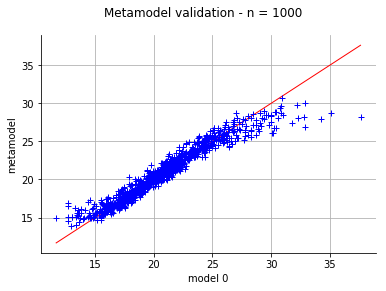

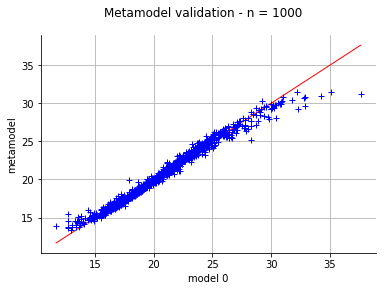

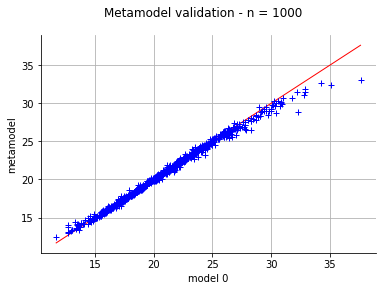

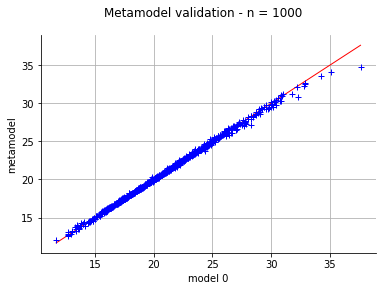

In [12]:
kriging_doe_LHS25.validation_results.getGraphs()
kriging_doe_LHS50.validation_results.getGraphs()
kriging_doe_LHS150.validation_results.getGraphs()
kriging_doe_LHS300.validation_results.getGraphs()

In [13]:
kriging_doe_LHS25.validation_results.getR2()
kriging_doe_LHS50.validation_results.getR2()
kriging_doe_LHS150.validation_results.getR2()
kriging_doe_LHS300.validation_results.getR2()

R2: [0.931127]
R2: [0.97947]
R2: [0.991379]
R2: [0.997801]


In [ ]:
sensitivityAnalysis_10000_2 = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensitivityAnalysis_10000_2.setDesign(sample_si_10000_in, sample_si_10000_out_MD, 10000)
sensitivityAnalysis_10000_2.setEstimator(ot.MartinezSensitivityAlgorithm())
sensitivityAnalysis_10000_2.getFirstOrderIndices()